### This example demonstrates the XCSF supervised learning mechanisms to perform regression
Classifiers are composed of tree GP conditions and neural network predictions. A single dummy action is performed such that [A] = [M].

In [1]:
from __future__ import annotations

import json

import graphviz
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import xcsf
from xcsf.utils.viz import TreeViz

np.set_printoptions(suppress=True)

RANDOM_STATE: int = 101

### Load training and test data
Loads the kin8nm dataset from: https://www.openml.org/d/189

"This is data set is concerned with the forward kinematics of an 8 link robot arm. Among the existing variants of this data set we have used the variant 8nm, which is known to be highly non-linear and medium noisy."

In [2]:
data = fetch_openml(data_id=189, as_frame=True, parser="auto")

data.frame.head()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,y
0,-0.015119,0.360741,0.469398,1.309675,0.988024,-0.025493,0.664071,0.062763,0.536524
1,0.360478,-0.301395,0.629183,-1.440146,-0.741637,-1.196749,-1.038444,-0.717461,0.308014
2,1.563238,-1.294753,0.078987,1.432937,1.149136,-1.292140,1.562988,-0.937731,0.518900
3,0.199485,0.901157,-1.356304,-0.080525,-0.976628,0.829894,-0.855649,0.930630,0.494151
4,0.659737,0.120552,-0.008756,0.648839,0.626832,-0.646539,1.318074,-0.899172,0.470218


In [3]:
data.frame.describe()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,y
count,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000
mean,0.009351,-0.007233,0.022792,-0.012945,0.007886,-0.009698,0.008402,0.001227,0.714283
std,0.904867,0.901496,0.900765,0.899186,0.906874,0.913243,0.909724,0.906098,0.263607
min,-1.570611,-1.570681,-1.570669,-1.570295,-1.570664,-1.570254,-1.570643,-1.568904,0.040165
25%,-0.770328,-0.778319,-0.749718,-0.780602,-0.770492,-0.802084,-0.776870,-0.777432,0.523584
50%,-0.002010,-0.015152,0.041346,-0.013617,0.009702,-0.003575,0.001338,0.002007,0.708822
75%,0.791179,0.779145,0.792391,0.760165,0.791203,0.781849,0.798014,0.780927,0.901354
max,1.570753,1.570657,1.570736,1.570169,1.570599,1.570597,1.570522,1.570237,1.458521


In [4]:
# numpy
X = np.asarray(data.data, dtype=np.float64)
y = np.asarray(data.target, dtype=np.float64)

# normalise inputs (zero mean and unit variance)
feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(X)

# reshape outputs into 2D arrays
if y.ndim == 1:
    y = y.reshape(-1, 1)

# normalise outputs (zero mean and unit variance)
output_scaler = StandardScaler()
y = output_scaler.fit_transform(y)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE
)

# 10% of training for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_STATE
)

print(f"X_train shape = {np.shape(X_train)}")
print(f"y_train shape = {np.shape(y_train)}")
print(f"X_val shape = {np.shape(X_val)}")
print(f"y_val shape = {np.shape(y_val)}")
print(f"X_test shape = {np.shape(X_test)}")
print(f"y_test shape = {np.shape(y_test)}")

X_DIM: int = np.shape(X_train)[1]
Y_DIM: int = np.shape(y_train)[1]

X_train shape = (6634, 8)
y_train shape = (6634, 1)
X_val shape = (738, 8)
y_val shape = (738, 1)
X_test shape = (820, 8)
y_test shape = (820, 1)


### Initialise XCSF

In [5]:
PERF_TRIALS: int = 5000
MAX_TRIALS: int = 200000
E0: float = 0.1

xcs = xcsf.XCS(
    x_dim=X_DIM,
    y_dim=Y_DIM,
    n_actions=1,
    omp_num_threads=12,
    random_state=RANDOM_STATE,
    pop_init=True,
    max_trials=MAX_TRIALS,
    perf_trials=PERF_TRIALS,
    pop_size=500,
    loss_func="mse",
    set_subsumption=False,
    theta_sub=100,
    e0=E0,
    alpha=1,
    nu=20,
    beta=0.1,
    delta=0.1,
    theta_del=50,
    init_fitness=0.01,
    init_error=0,
    m_probation=10000,
    stateful=True,
    compaction=False,
    ea={
        "select_type": "roulette",
        "theta_ea": 50,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": False,
        "pred_reset": False,
    },
    condition={
        "type": "tree_gp",
        "args": {
            "min_constant": 0,
            "max_constant": 1,
            "n_constants": 100,
            "init_depth": 5,
            "max_len": 10000,
        },
    },
    prediction={
        "type": "neural",
        "args": {
            "layer_0": {
                "type": "connected",
                "activation": "selu",
                "n_init": 40,
                "evolve_weights": True,
                "evolve_functions": False,
                "evolve_connect": True,
                "evolve_neurons": False,
                "sgd_weights": True,
                "eta": 0.1,
                "evolve_eta": True,
                "eta_min": 1e-06,
                "momentum": 0.9,
                "decay": 0,
            },
            "layer_1": {
                "type": "connected",
                "activation": "selu",
                "n_init": 1,
                "evolve_weights": True,
                "evolve_functions": False,
                "evolve_connect": True,
                "evolve_neurons": False,
                "sgd_weights": True,
                "eta": 0.1,
                "evolve_eta": True,
                "eta_min": 1e-06,
                "momentum": 0.9,
                "decay": 0,
            },
        },
    },
)

print(json.dumps(xcs.internal_params(), indent=4))

{
    "version": "1.3.0",
    "x_dim": 8,
    "y_dim": 1,
    "n_actions": 1,
    "omp_num_threads": 12,
    "random_state": 101,
    "population_file": "",
    "pop_init": true,
    "max_trials": 200000,
    "perf_trials": 5000,
    "pop_size": 500,
    "loss_func": "mse",
    "set_subsumption": false,
    "theta_sub": 100,
    "e0": 0.1,
    "alpha": 1,
    "nu": 20,
    "beta": 0.1,
    "delta": 0.1,
    "theta_del": 50,
    "init_fitness": 0.01,
    "init_error": 0,
    "m_probation": 10000,
    "stateful": true,
    "compaction": false,
    "ea": {
        "select_type": "roulette",
        "theta_ea": 50,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": false,
        "pred_reset": false
    },
    "condition": {
        "type": "tree_gp",
        "args": {
            "min_constant": 0,
            "max_constant": 1,
            "n_constants": 100,
            "init_depth": 5,
            "max_len": 10000
 

### Fit XCSF

In [6]:
# use optional callback
callback = xcsf.EarlyStoppingCallback(
    # note: PERF_TRIALS is considered an "epoch" for callbacks
    monitor="val",  # which metric to monitor: {"train", "val"}
    patience=20000,  # trials with no improvement after which training will be stopped
    restore_best=True,  # whether to make checkpoints and restore best population
    min_delta=0,  # minimum change to qualify as an improvement
    start_from=0,  # trials to wait before starting to monitor improvement
    verbose=True,  # whether to display when checkpoints are made
)

xcs.fit(
    X_train, y_train, validation_data=(X_val, y_val), callbacks=[callback], verbose=True
)

2023-07-19T16:11:40.856 trials=5000 train=3.41064 val=0.21619 pset=500.0 mset=221.0 mfrac=1.00
2023-07-19T16:11:40.860 EarlyStoppingCallback: 0.21619 best error at 5000 trials
2023-07-19T16:11:42.264 trials=10000 train=0.20387 val=0.15431 pset=500.0 mset=238.7 mfrac=1.00
2023-07-19T16:11:42.270 EarlyStoppingCallback: 0.15431 best error at 10000 trials
2023-07-19T16:11:43.899 trials=15000 train=0.15907 val=0.13559 pset=500.0 mset=415.4 mfrac=1.00
2023-07-19T16:11:43.907 EarlyStoppingCallback: 0.13559 best error at 15000 trials
2023-07-19T16:11:45.932 trials=20000 train=0.13632 val=0.12527 pset=500.0 mset=459.8 mfrac=0.36
2023-07-19T16:11:45.942 EarlyStoppingCallback: 0.12527 best error at 20000 trials
2023-07-19T16:11:47.897 trials=25000 train=0.24788 val=0.12312 pset=500.0 mset=456.0 mfrac=1.00
2023-07-19T16:11:47.901 EarlyStoppingCallback: 0.12312 best error at 25000 trials
2023-07-19T16:11:49.716 trials=30000 train=0.12170 val=0.11512 pset=500.0 mset=448.5 mfrac=1.00
2023-07-19T16:11

### Plot XCSF learning performance

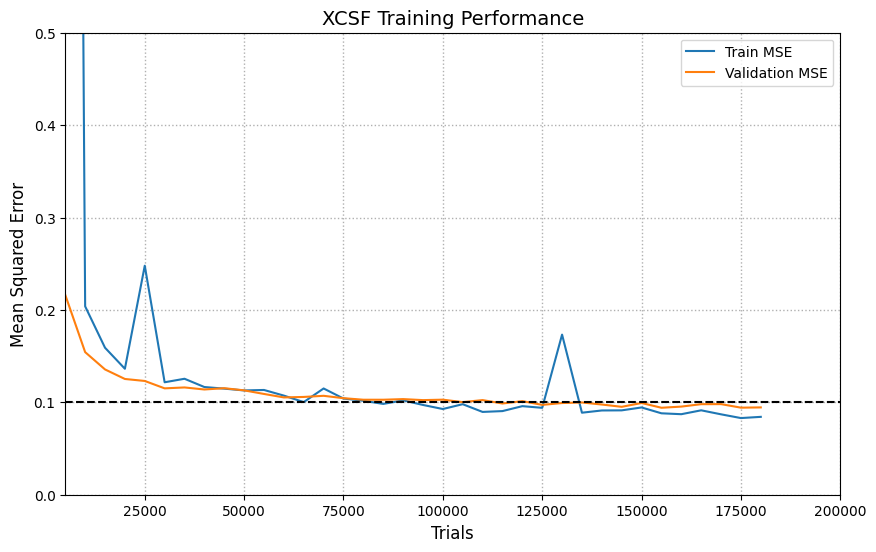

In [7]:
metrics: dict = xcs.get_metrics()
plt.figure(figsize=(10, 6))
plt.plot(metrics["trials"], metrics["train"], label="Train MSE")
plt.plot(metrics["trials"], metrics["val"], label="Validation MSE")
plt.grid(linestyle="dotted", linewidth=1)
plt.axhline(y=E0, xmin=0, xmax=1, linestyle="dashed", color="k")
plt.title("XCSF Training Performance", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.ylim([0, 0.5])
plt.xlim([PERF_TRIALS, MAX_TRIALS])
plt.legend()
plt.show()

### Final XCSF test score

In [8]:
xcsf_pred = xcs.predict(X_test)
xcsf_mse = mean_squared_error(xcsf_pred, y_test)
print(f"XCSF Test MSE = {xcsf_mse:.4f}")

XCSF Test MSE = 0.1060


### Compare with alternatives

In [9]:
X_train = np.vstack((X_train, X_val))
y_train = np.vstack((y_train, y_val))

In [10]:
regressors = []

In [11]:
regressors.append(LinearRegression())

In [12]:
regressors.append(
    MLPRegressor(
        random_state=RANDOM_STATE,
        hidden_layer_sizes=(40,),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        learning_rate_init=0.01,
        max_iter=1000,
        alpha=0.01,
        validation_fraction=0.1,
    )
)

In [13]:
regressors.append(RandomForestRegressor(random_state=RANDOM_STATE))

In [14]:
regressors.append(GaussianProcessRegressor(random_state=RANDOM_STATE))

In [15]:
for model in regressors:
    model.fit(X_train, y_train.ravel())
    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    print(f"{model.__class__.__name__} Test MSE = {mse:.4f}")

LinearRegression Test MSE = 0.6085
MLPRegressor Test MSE = 0.1143
RandomForestRegressor Test MSE = 0.3020
GaussianProcessRegressor Test MSE = 0.1156


### Visualise the lowest error rule in the population set

Condition (matches when output node > 0.5):


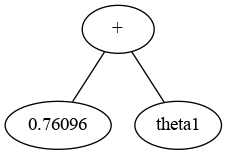

In [16]:
print("Condition (matches when output node > 0.5):")
parsed = json.loads(xcs.json())
parsed = sorted(  # sort population by error
    parsed["classifiers"], key=lambda d: d["error"]
)
trees = [cl["condition"]["tree"]["array"] for cl in parsed]
TreeViz(trees[0], "best", feature_names=data.feature_names)
with open("best.gv") as f:
    dot = f.read()
    tree = graphviz.Source(dot)
    tree.format = "png"
    tree.render("best")
    display(Image("best.png"))

In [17]:
def print_attributes(cl: dict) -> None:
    """Prints a classifier's attributes."""
    print(f"Error: {cl['error']:.5f}")
    print(f"Fitness: {cl['fitness']:.5f}")
    print(f"Accuracy: {cl['accuracy']:.5f}")
    print(f"Average Set Size: {cl['set_size']:.2f}")
    print(f"Numerosity: {cl['numerosity']}")
    print(f"Experience: {cl['experience']}")
    print(f"Samples Seen: {cl['samples_seen']}")
    print(f"Samples Matched: {cl['samples_matched']}")


print_attributes(parsed[0])

Error: 0.04031
Fitness: 0.00712
Accuracy: 1.00000
Average Set Size: 465.37
Numerosity: 1
Experience: 2748
Samples Seen: 6270
Samples Matched: 3638
